In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
import pickle
from tqdm import tqdm
import math 
import time
import csv
import glob
import os

import logging
import random
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)




In [2]:
from load_training_data_segment_based import SegmentBasedDataLoader
### 使用改进的分段数据加载器
trial_id = 'test_0808_5'

# 配置数据加载参数
train_folder = r'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\data\model_training_by_motion\train'
test_folder = r'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\data\model_training_by_motion\test'
scaler_dir = r'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\predict\scaler'

# 创建基于分段的数据加载器
segment_data_loader = SegmentBasedDataLoader(
    train_folder=train_folder,
    test_folder=test_folder,
    window_size=60,           # 对应原来的 window_length
    time_step=1,              # 对应原来的 time_steps
    sensor_cols_range=(1, 15),  # 第2~15列 (传感器数据)
    angle_cols_range=(15, 42),  # 第16~42列 (27个角度)
    batch_size=256,
    validation_split=0.2,
    scaler_save_dir=scaler_dir,
    trial_id=trial_id
)

# 加载和预处理数据
segment_data_loader.load_and_prepare_data()

# 获取数据加载器和归一化器
train_loader, val_loader, test_loader = segment_data_loader.get_data_loaders()
sensor_scaler, angle_scaler = segment_data_loader.get_scalers()

print("✅ 分段数据加载完成!")


🚀 开始加载基于分段的训练数据...

📈 加载训练数据...
🔍 正在扫描文件夹: F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\data\model_training_by_motion\train
📁 找到 60 个CSV文件
📊 处理文件 1/60: P1_AB_fps60.csv
   ✓ 生成 1911 个窗口
📊 处理文件 2/60: P1_AB_fps90.csv
   ✓ 生成 1001 个窗口
📊 处理文件 3/60: P1_C_AB_fps30_moni15.csv
   ✓ 生成 1911 个窗口
📊 处理文件 4/60: P1_C_AB_fps30_qugan_5kg_L.csv
   ✓ 生成 1910 个窗口
📊 处理文件 5/60: P1_C_AB_fps30_songjian_5kg_L.csv
   ✓ 生成 1911 个窗口
📊 处理文件 6/60: P1_C_AB_fps30_songjian_5kg_R.csv
   ✓ 生成 1910 个窗口
📊 处理文件 7/60: P1_C_HF_fps30_moni15.csv
   ✓ 生成 1910 个窗口
📊 处理文件 8/60: P1_C_HF_fps30_qugan_5kg.csv
   ✓ 生成 1910 个窗口
📊 处理文件 9/60: P1_C_HF_fps30_songjian_5kg_L.csv
   ✓ 生成 1910 个窗口
📊 处理文件 10/60: P1_C_RH_fps30_quganxuanzhuan_L.csv
   ✓ 生成 1001 个窗口
📊 处理文件 11/60: P1_HF_fps30.csv
   ✓ 生成 1910 个窗口
📊 处理文件 12/60: P1_HF_fps60.csv
   ✓ 生成 1910 个窗口
📊 处理文件 13/60: P1_HF_fps90.csv
   ✓ 生成 1002 个窗口
📊 处理文件 14/60: P1_RH_external.csv
   ✓ 生成 1002 个窗口
📊 处理文件 15/60: P1_RH_fps30.csv
   ✓ 生成 1911 个窗口
📊 处理文件 16/60: P1_RH_fps60.csv
   ✓ 生成 1911 个窗口

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # 输出使用的设备

# Set the model parameters
input_size = 14
# conv_input = 10
hidden_size = 256
num_layers = 2
output_size = 27
dropout = 0.3
# Set training parameters
num_epochs = 300


from model import LSTM, ImprovedLSTM
# model = LSTM_op(input_size, hidden_size, num_layers, output_size, dropout).to(device)
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)
# model = ImprovedLSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(model)

Using device: cuda
LSTM(
  (lstm): LSTM(14, 256, num_layers=2, batch_first=True)
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=27, bias=True)
  )
)


In [4]:

from enhanced_loss_module import EnhancedLossFunction, get_recommended_weights

def l2_regularizer(weight, lambda_l2):
    return lambda_l2 * torch.norm(weight, 2)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
enhanced_loss = EnhancedLossFunction(alpha=1.0, beta=0.08, gamma=0.03, delta=0.15)
# 保留原来的MSE用于验证阶段（可选）
criterion = nn.MSELoss()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses = []
val_losses = []  

# 设置早停参数
loss_components_history = {'mse': [], 'trend': [], 'hysteresis': [], 'smoothness': []}


early_stopping_patience = 10  # 连续多少个epoch验证损失没有改善则停止
early_stopping_threshold = 1e-05  # 损失减少小于这个阈值时认为没有改善

# 添加一个队列来存放最近的验证损失值
recent_val_losses = deque(maxlen=early_stopping_patience)
# 获取当前时间戳
current_time = time.strftime("%Y%m%d-%H%M%S")
# log_file_path = f'01dataprocess_code/data/result/{participant_id}/training_log_{participant_id}_{current_time}.txt'
log_file_path = f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\log\\training_log\log_{trial_id}.txt'
model_params = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'num_epochs': num_epochs,
    'learning_rate': 0.001,
    'lambda_l2': 0.0003,
    'early_stopping_patience': early_stopping_patience,
    'early_stopping_threshold': early_stopping_threshold
}

初始化增强损失函数:
  MSE权重(α): 1.0
  趋势损失权重(β): 0.08
  迟滞惩罚权重(γ): 0.03
  平滑正则权重(δ): 0.15
  迟滞阈值: 0.03


In [5]:
# 打开文件以便写入
with open(log_file_path, 'w') as log_file:
    # 写入模型参数到日志文件
    log_file.write("Model Parameters:\n")
    for param_name, param_value in model_params.items():
        log_file.write(f"{param_name}: {param_value}\n")
    # 添加损失函数权重信息
    log_file.write(f"Enhanced Loss Weights: alpha={enhanced_loss.alpha}, beta={enhanced_loss.beta}, "
                   f"gamma={enhanced_loss.gamma}, delta={enhanced_loss.delta}\n")
    log_file.write("\n")

    model.train()
    best_val_loss = float('inf')  # 初始化最好的验证损失为正无穷大
    stop_training = False

    print(f"Start training, totally {num_epochs} epoch...")
    print("-" * 80)
    start_time = time.time()
    
    for epoch in range(num_epochs):
        if stop_training:
            print(f"\n Early stop at {epoch} epoch")
            log_file.write(f"Early stopping triggered at epoch {epoch}\n")
            break

        model.train()
        epoch_start_time = time.time()
        
        # 简单显示当前epoch进度
                # 记录当前epoch的损失组件
        epoch_loss_components = {'mse': 0, 'trend': 0, 'hysteresis': 0, 'smoothness': 0}
        batch_count = 0
        total_batches = len(train_loader)
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 原始传感器振幅的loss
            optimizer.zero_grad()
            output = model(X_batch)

            # === 原来的损失计算（注释掉）===
            # train_loss = criterion(output, y_batch)

            # === 新的增强损失计算 ===
            # 为迟滞惩罚提供传感器输入
            sensor_input = X_batch[:, -1, :]  # 使用最后一个时间步的传感器数据
            
            # 计算增强损失
            loss_dict = enhanced_loss.compute_loss(output, y_batch, sensor_input)
            train_loss = loss_dict['total_loss']

            # 记录各组件损失
            epoch_loss_components['mse'] += loss_dict['mse_loss'].item()
            epoch_loss_components['trend'] += loss_dict['trend_loss'].item()
            epoch_loss_components['hysteresis'] += loss_dict['hysteresis_loss'].item()
            epoch_loss_components['smoothness'] += loss_dict['smoothness_loss'].item()

            # 正则化
            l2_reg = 0
            for param in model.parameters():
                l2_reg += l2_regularizer(param, lambda_l2=0.0003)
            loss = train_loss + l2_reg
            loss.backward()
            optimizer.step()
            
            batch_count += 1

        # 计算平均损失组件
        for key in epoch_loss_components:
            epoch_loss_components[key] /= len(train_loader)
            loss_components_history[key].append(epoch_loss_components[key])

        # 更新学习率
        scheduler.step()
        model.eval()
        val_loss_total = 0
        with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # ✅ 添加这一行
                    output = model(X_batch)
                    # 验证阶段可以使用简单MSE，或者也使用增强损失
                    val_loss = criterion(output, y_batch)
                    val_loss_total += val_loss.item()
                    # 或者使用增强损失：
                    # sensor_input = X_batch[:, -1, :]
                    # val_loss_dict = enhanced_loss.compute_loss(output, y_batch, sensor_input)
                    # val_loss = val_loss_dict['total_loss']

                    
        val_loss_avg = val_loss_total / len(val_loader)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss_avg)
        
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # 每10个epoch或者最后一个epoch显示详细信息
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            progress = (epoch + 1) / num_epochs * 100
            eta = (total_time / (epoch + 1)) * (num_epochs - epoch - 1)
            
            print(f"Epoch {epoch+1:3d}/{num_epochs} ({progress:5.1f}%) | "
                  f"Train: {train_loss.item():.8f} | Val: {val_loss_avg:.8f} | "
                  f"Time: {epoch_time:.6f}s | ETA: {eta/60:.1f}min")
            print(f"  Components - MSE: {epoch_loss_components['mse']:.6f} | "
                  f"Trend: {epoch_loss_components['trend']:.6f} | "
                  f"Hysteresis: {epoch_loss_components['hysteresis']:.6f} | "
                  f"Smooth: {epoch_loss_components['smoothness']:.6f}")
            

        # 每个epoch简单显示一个点表示进度
        elif epoch % 1 == 0:
            print("-", end="", flush=True)
            
        log_file.write(f"epoch:{epoch}, train_loss:{train_loss.item()}, val_loss:{val_loss_avg}\n")
        log_file.write(f"  components - mse:{epoch_loss_components['mse']:.8f}, "
                      f"trend:{epoch_loss_components['trend']:.8f}, "
                      f"hysteresis:{epoch_loss_components['hysteresis']:.8f}, "
                      f"smoothness:{epoch_loss_components['smoothness']:.8f}\n")

        # 如果当前的验证损失比之前最好的验证损失好，更新最好的验证损失
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
        
        # 将当前验证损失添加到队列中
        recent_val_losses.append(val_loss_avg)
        
        # 检查队列中的损失是否没有显著减少
        if len(recent_val_losses) == early_stopping_patience:
            if all((recent_val_losses[i-1] - recent_val_losses[i]) < early_stopping_threshold for i in range(1, len(recent_val_losses))):
                stop_training = True

    # Save the model
    total_training_time = time.time() - start_time
    model_save_path = f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\model\{trial_id}_lstm.pth'
    torch.save(model.state_dict(), model_save_path)
    
    print(f"\n" + "=" * 80)
    print(f"训练完成！总耗时: {total_training_time/60:.1f} 分钟")
    print(f"模型已保存: {model_save_path}")
    print(f"最终结果 - Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss_avg:.4f}")
    print(f"最佳验证损失: {best_val_loss:.4f}")
    print("=" * 80)
    
    log_file.write(f"模型已保存为 {model_save_path}\n")
    log_file.write(f"总训练时间: {total_training_time/60:.1f} 分钟\n")
    
print(f"Training log saved to {log_file_path}")

Start training, totally 300 epoch...
--------------------------------------------------------------------------------
Epoch   1/300 (  0.3%) | Train: 0.03693311 | Val: 0.01557084 | Time: 9.387581s | ETA: 46.8min
  Components - MSE: 0.026840 | Trend: 0.048253 | Hysteresis: 0.013595 | Smooth: 0.109917
---------Epoch  11/300 (  3.7%) | Train: 0.02677148 | Val: 0.01107298 | Time: 8.179147s | ETA: 39.6min
  Components - MSE: 0.011489 | Trend: 0.022856 | Hysteresis: 0.002457 | Smooth: 0.078852
---------Epoch  21/300 (  7.0%) | Train: 0.02779381 | Val: 0.01450475 | Time: 8.148317s | ETA: 38.0min
  Components - MSE: 0.011917 | Trend: 0.023744 | Hysteresis: 0.006806 | Smooth: 0.075563
---------Epoch  31/300 ( 10.3%) | Train: 0.02236463 | Val: 0.01039750 | Time: 7.751125s | ETA: 36.3min
  Components - MSE: 0.010699 | Trend: 0.021351 | Hysteresis: 0.004232 | Smooth: 0.080498
---------Epoch  41/300 ( 13.7%) | Train: 0.02242761 | Val: 0.01076704 | Time: 7.820202s | ETA: 34.6min
  Components - MSE: 

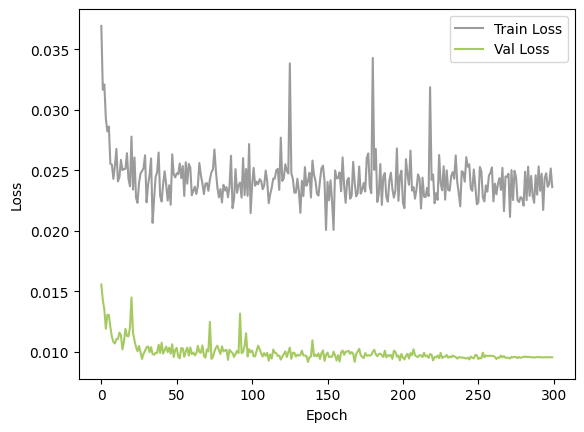

C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\74754\AppData\Local\Temp\ipykernel_62100\2516198738.py:43: UserWarning: Glyph 36235 (\

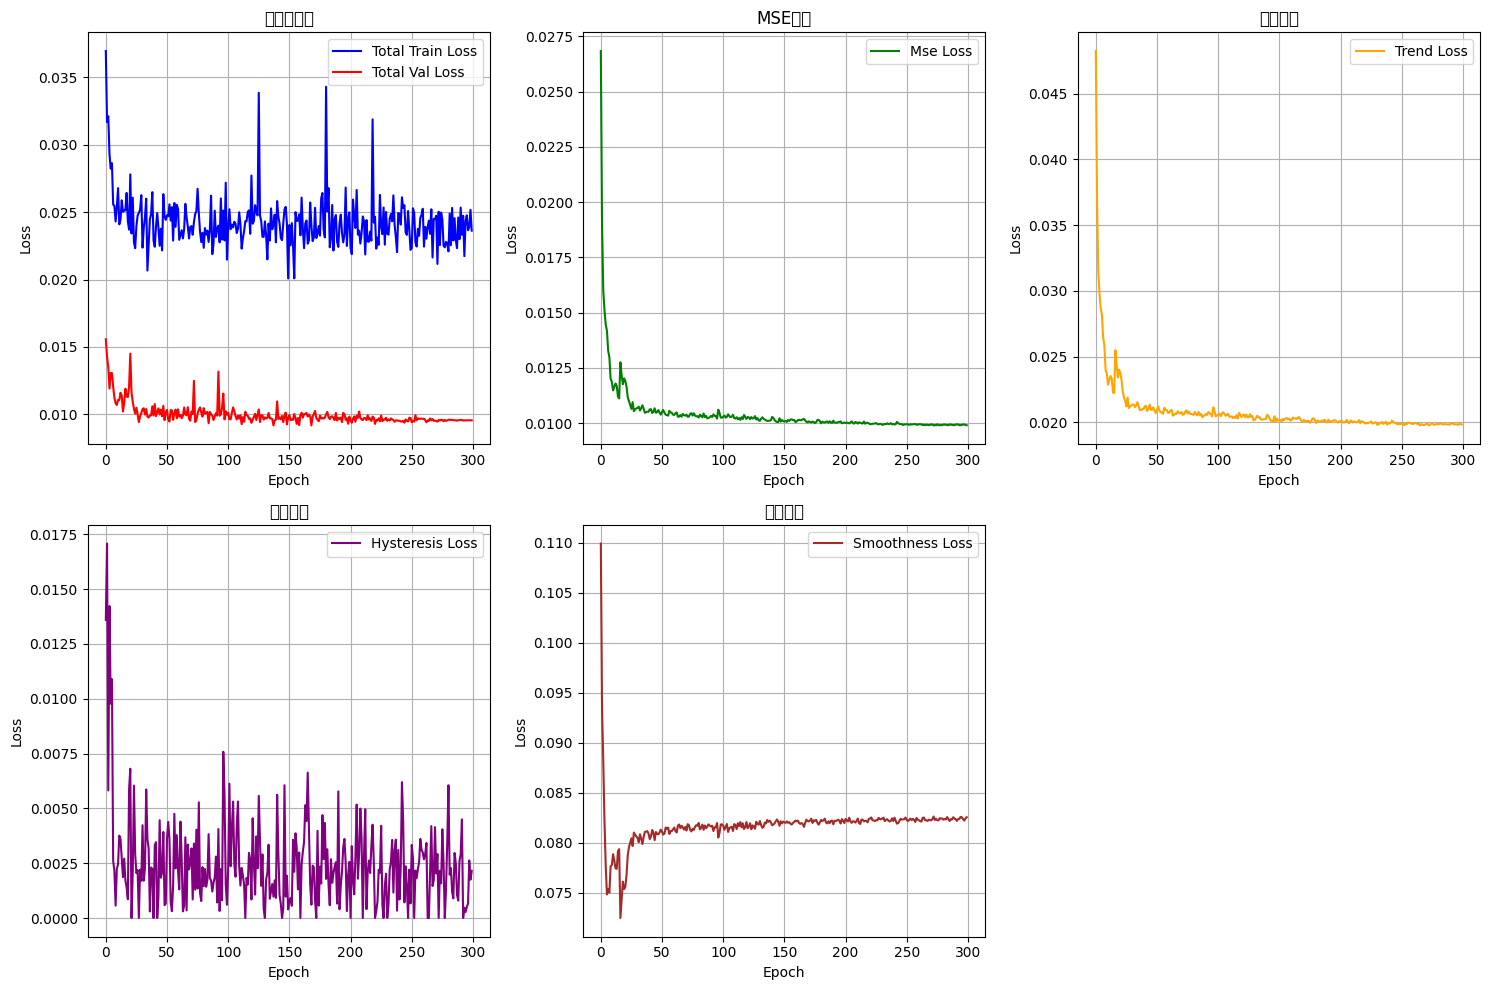

In [6]:
import os
# 创建保存图像的路径
result_dir = f'./result/figure/{trial_id}'
os.makedirs(result_dir, exist_ok=True)  # 如果文件夹不存在则创建
# 保存图像的文件路径
image_path_loss = f'{result_dir}\\{trial_id}_{current_time}_loss_plot.png'

plt.plot(train_losses, label='Train Loss', color = '#9B9B9B')
plt.plot(val_losses, label='Val Loss', color = '#A5CA61')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(image_path_loss)  # 保存图像到文件
plt.show()

# 新增：损失组件分析图
plt.figure(figsize=(15, 10))

# 总损失曲线
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Total Train Loss', color='blue')
plt.plot(val_losses, label='Total Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('总损失曲线')
plt.legend()
plt.grid(True)

# 各组件损失曲线
components = ['mse', 'trend', 'hysteresis', 'smoothness']
colors = ['green', 'orange', 'purple', 'brown']
titles = ['MSE损失', '趋势损失', '迟滞惩罚', '平滑正则']

for i, (component, color, title) in enumerate(zip(components, colors, titles)):
    plt.subplot(2, 3, i+2)
    plt.plot(loss_components_history[component], label=f'{component.capitalize()} Loss', color=color)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
image_path_enhanced_loss = f'{result_dir}\\{trial_id}_{current_time}_enhanced_loss_analysis.png'
plt.savefig(image_path_enhanced_loss, dpi=300, bbox_inches='tight')
plt.show()

In [8]:
model.load_state_dict(torch.load(f'F:\coding\ShoulDeX\ShoulDex_v1.0\ShoulDex_v1.5\model\\{trial_id}_lstm.pth'))
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    test_outputs = model(X_test)

NameError: name 'X_train' is not defined

In [9]:
print("X_batch shape:", X_batch.shape)  # 输入的形状
print("output shape:", output.shape)    # 输出的形状
print("y_batch shape:", y_batch.shape)  # 目标值的形状

X_batch shape: torch.Size([117, 60, 14])
output shape: torch.Size([117, 27])
y_batch shape: torch.Size([117, 27])


In [10]:
# Calculate the RMSE for each dimension separately
def calculate_rmse(y_true, y_pred):
    rmse_per_dimension = []
    # mean_true = np.mean(y_true)
    for i in range(y_true.shape[1]):
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        # normalized_error_mean = rmse / mean_true

        rmse_per_dimension.append(rmse)

    return rmse_per_dimension


# 计算归一化数据的 RMSE
train_rmse_normalized = calculate_rmse(y_train.cpu(), train_outputs.cpu())
test_rmse_normalized = calculate_rmse(y_test.cpu(), test_outputs.cpu())

# Calculate the RMS
y_train_inv = angle_scaler.inverse_transform(y_train.cpu())
train_pred_inv = angle_scaler.inverse_transform(train_outputs.cpu())
train_rmse_per_dim = calculate_rmse(y_train_inv, train_pred_inv)

y_test_inv = angle_scaler.inverse_transform(y_test.cpu())
test_pred_inv = angle_scaler.inverse_transform(test_outputs.cpu())
test_rmse_per_dim = calculate_rmse(y_test_inv, test_pred_inv)

print(f"NORMALIZED Train RMSE per dimension: {train_rmse_normalized}")
print(f"NORMALIZED Test RMSE per dimension: {test_rmse_normalized}")

print(f"Train RMSE per dimension: {train_rmse_per_dim}")
print(f"Test RMSE per dimension: {test_rmse_per_dim}")

NameError: name 'y_train' is not defined

In [ ]:
print("train_pred_inv shape:", train_pred_inv.shape)
print("y_train_inv shape:", y_train_inv.shape)
print("test_pred_inv shape:", test_pred_inv.shape)
print("y_test_inv shape:", y_test_inv.shape)

# 计算训练集和测试集上RMSE的平均值
train_rmse_mean = np.mean(train_rmse_per_dim)
test_rmse_mean = np.mean(test_rmse_per_dim)
print(f"Average Train RMSE: {train_rmse_mean}")
print(f"Average Test RMSE: {test_rmse_mean}")


train_pred_inv shape: (19858, 27)
y_train_inv shape: (19858, 27)
test_pred_inv shape: (8967, 27)
y_test_inv shape: (8967, 27)
Average Train RMSE: 6.993649129537776
Average Test RMSE: 11.264596961844553


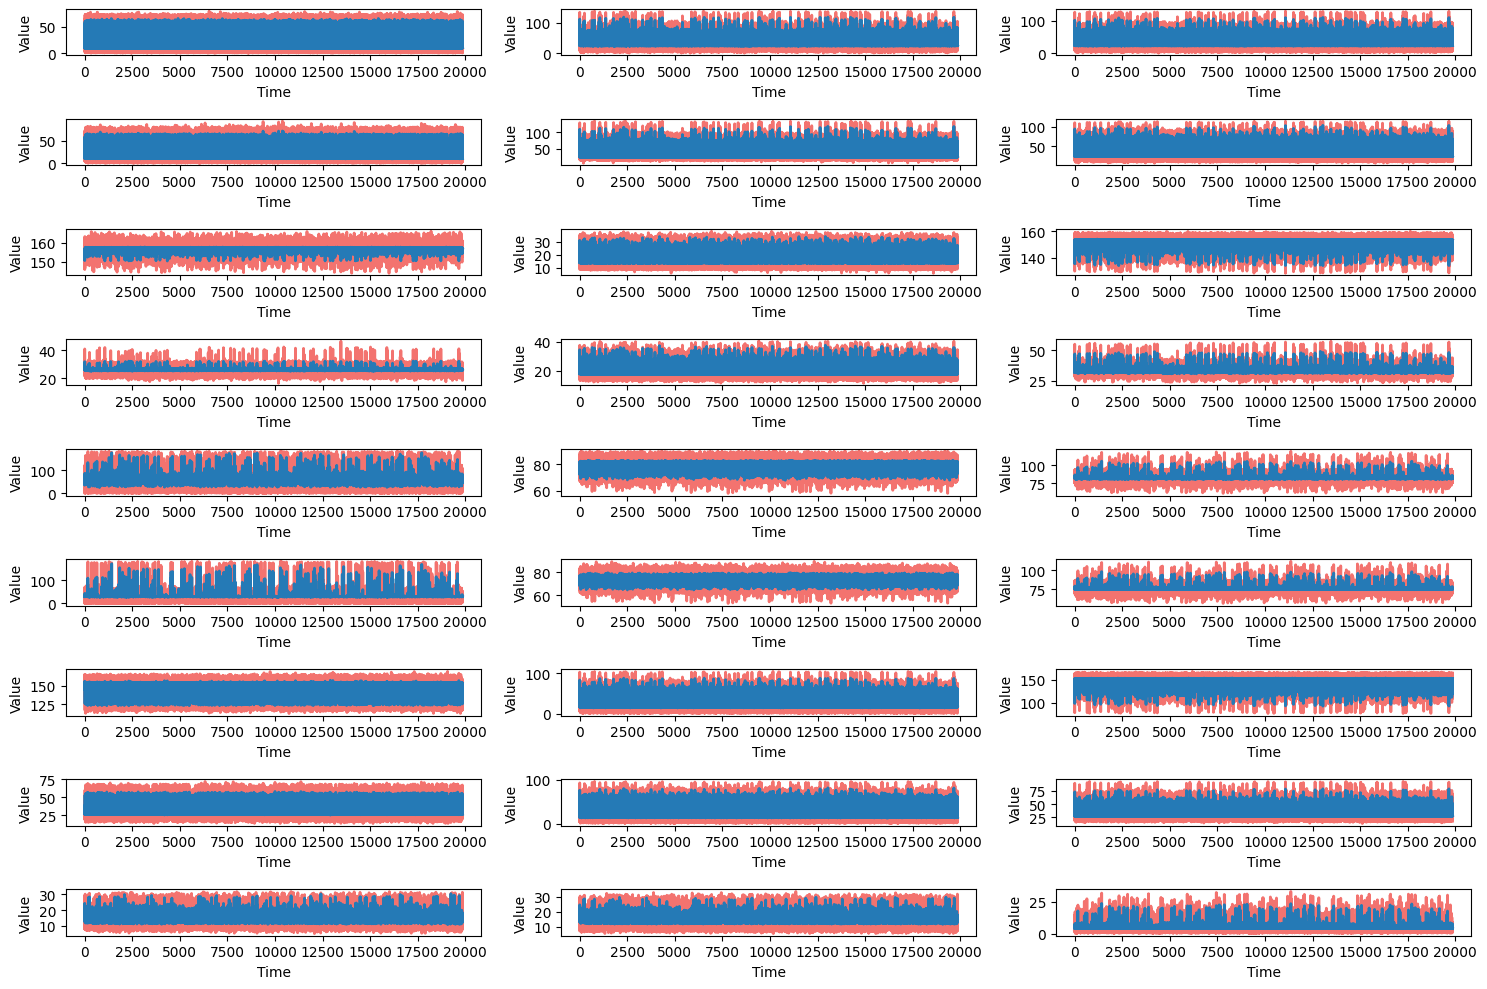

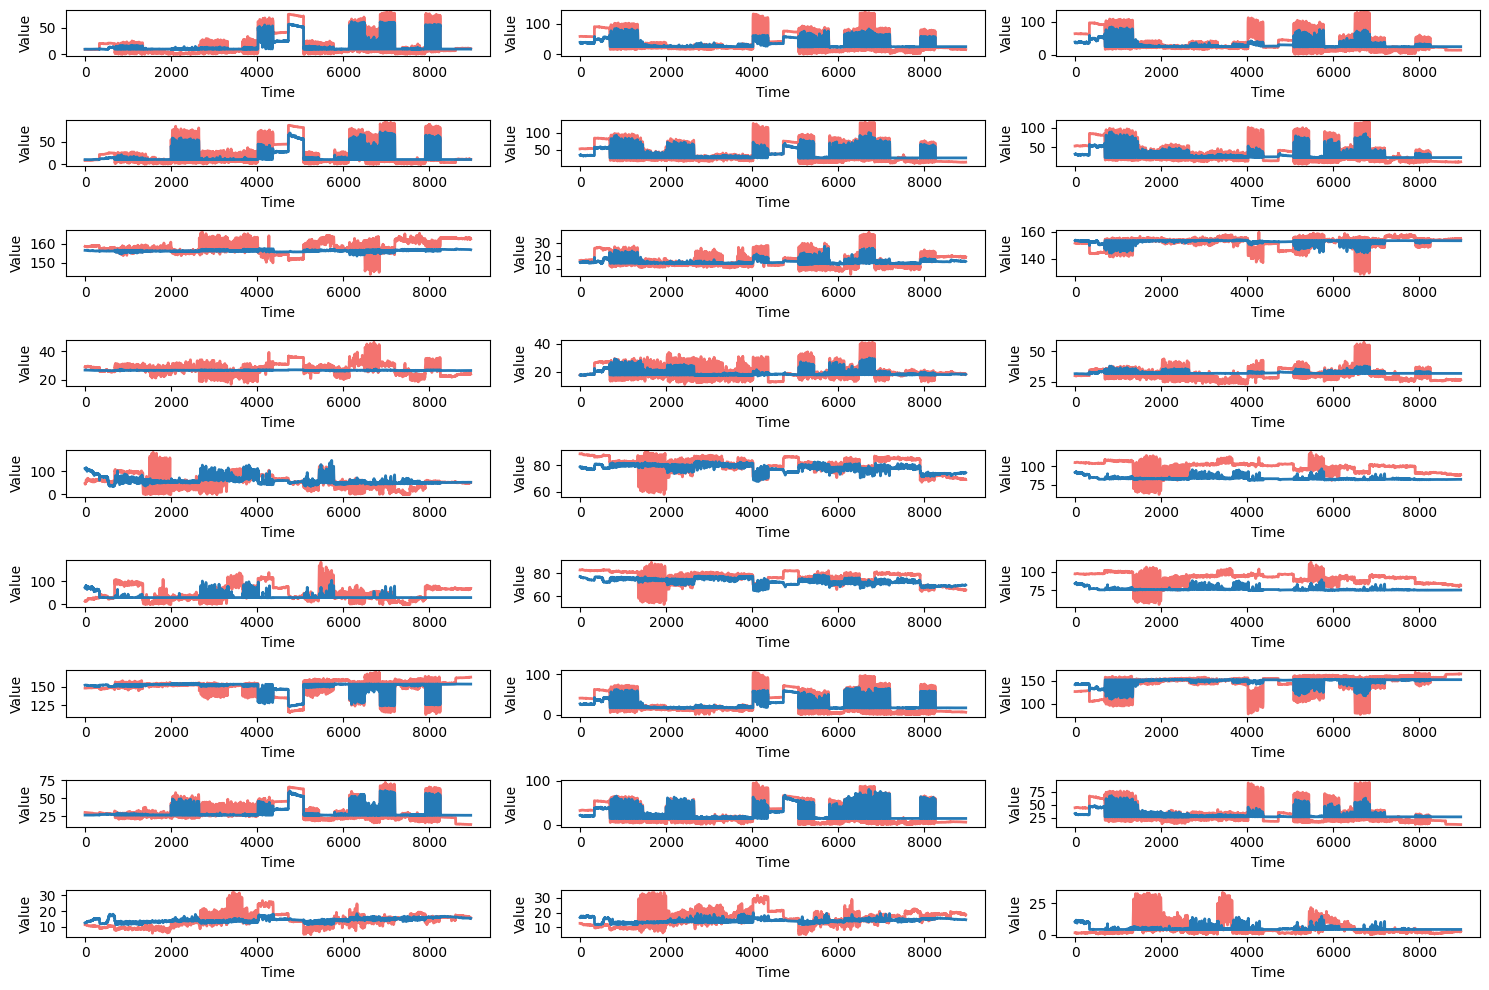

In [ ]:

# 保存图像的文件路径
image_path_angleresult_train = f'{result_dir}\\{trial_id}_{current_time}_res_train.png'
# Plotting for training set
plt.figure(figsize=(15, 10))
for i in range(y_train_inv.shape[1]):
    plt.subplot(9, 3, i+1)
    plt.plot(y_train_inv[:, i], label='Actual Train', color ="#F3736F", linewidth = 2.0 )
    plt.plot(train_pred_inv[:, i], label='Predicted Train', color ="#257AB6", linewidth = 2.0 )
    # plt.legend()
    # plt.title(f'Actual vs Predicted - Train (Dimension {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.savefig(image_path_angleresult_train)  # 保存图像到文件
plt.show()

# Plotting for test set
image_path_angleresult_test = f'{result_dir}\\{trial_id}_{current_time}_res_test.png'
plt.figure(figsize=(15, 10))
for i in range(y_test_inv.shape[1]):
    plt.subplot(9, 3, i+1)
    plt.plot(y_test_inv[:, i], label='Actual Test', color ="#F3736F" , linewidth = 2.0)
    plt.plot(test_pred_inv[:, i], label='Predicted Test' , color ="#257AB6" , linewidth = 2.0)
    # plt.legend()
    # plt.title(f'Actual vs Predicted - Test (Dimension {i+1})')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.savefig(image_path_angleresult_test)  # 保存图像到文件
plt.show()



In [ ]:
# 计算训练集和测试集上RMSE的平均值
train_rmse_mean = np.mean(train_rmse_per_dim)
print(f"Average Train RMSE: {train_rmse_mean}")

header = ['angle1_groundtruth', 'angle1_pred', 'angle2_groundtruth', 'angle2_pred', 'angle3_groundtruth', 'angle3_pred', 'angle4_groundtruth', 'angle4_pred', 'angle5_groundtruth', 'angle5_pred', 'angle6_groundtruth', 'angle6_pred', 'angle7_groundtruth', 'angle7_pred', 'angle8_groundtruth', 'angle8_pred', 'angle9_groundtruth', 'angle9_pred' ]
# header = ['angle1_groundtruth', 'angle1_pred', 'angle2_groundtruth', 'angle2_pred', 'angle3_groundtruth', 'angle3_pred']

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_train_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for row_idx in range(y_train_inv.shape[0]):
        merge_row = []
        for col_idx in range(y_train_inv.shape[1]):
            merge_row.append(y_train_inv[row_idx][col_idx])
            merge_row.append(train_pred_inv[row_idx][col_idx])
        writer.writerow(merge_row)

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_test_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for row_idx in range(y_test_inv.shape[0]):
        merge_row = []
        for col_idx in range(y_test_inv.shape[1]):
            merge_row.append(y_test_inv[row_idx][col_idx])
            merge_row.append(test_pred_inv[row_idx][col_idx])
        writer.writerow(merge_row)

with open(f'01dataprocess_code\data\\result/{body_part}\{participant_id}/{participant_id}_{test_or_final}_{current_time}_RMSE.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    header = ['NORMALIZED Train RMSE per dimension', 'NORMALIZED Test RMSE per dimension', 'Train RMSE per dimension', 'Test RMSE per dimension', 'Average Train RMSE', 'Average Test RMSE']
    writer.writerow(header)
    for i in range(angle_number):
        row = [train_rmse_normalized[i], test_rmse_normalized[i], train_rmse_per_dim[i], test_rmse_per_dim[i]]
        if i == 0:
            row.extend([train_rmse_mean, test_rmse_mean])
        else:
            row.extend(['',''])
        writer.writerow(row)



Average Train RMSE: 2.582934587347135
